### Creación de los directorios de entrenamiento y testeo

In [5]:
import os, shutil
os.getcwd()

'C:\\Users\\theac\\Desktop\\Repo TFG\\notebooks'

In [27]:
# directorio con el datset de entrenamiento y testo
test_train_dir = os.path.join(os.getcwd(), 'test_train')
os.mkdir(test_train_dir)

In [28]:
# directorio de entrenamiento
train_dir = os.path.join('test_train', 'train')
os.mkdir(train_dir)

# directorio de validación
val_dir = os.path.join('test_train', 'validation')
os.mkdir(val_dir)

# directorio de testeo
test_dir = os.path.join('test_train', 'test')
os.mkdir(test_dir)

Si fuese un problema de clasificación binaria únicamente habrían 2 clases, pero al tratarse de clasificación multiclase se necesitan más de 2 clases que en este caso se corresponden con el número de sujetos que tenemos en nuestra base de datos.

In [30]:
sujetos = len(os.listdir('CASIA-IrisV1')) # nro de clases/sujetos
sujetos

108

En este caso lo que se hará será coger las muestras de la sesión 1 (3 muestras) para entrenar la red y las de la sesión 2 (4 muestras) para la validación y testeo(2 y 2)

In [31]:
for i in range(1, sujetos+1): # nombrar sujetos del 1 al 108
    # subdirectorios de entrenamiento con 108 clases
    os.mkdir(os.path.join(train_dir, 'sujeto_' + str(i)))
    
    # subdirectorio de testeo con 108 clases
    os.mkdir(os.path.join(val_dir, 'sujeto_' + str(i)))

    # subdirectorio de testeo con 108 clases
    os.mkdir(os.path.join(test_dir, 'sujeto_' + str(i)))

In [26]:
# shutil.rmtree('test_train')

In [32]:
# ordenaremos cada una de las muestras en sus correspondientes directorios
j = 1
for file in os.listdir('CASIA-IrisV1'):
    path_to_session = 'CASIA-IrisV1' + os.sep + file
    for i, session in enumerate(os.listdir(path_to_session)):
        src = path_to_session + os.sep + session
        for eye in os.listdir(src):
            if i == 0: # copiamos al directorio de entrenamiento
                # pertenece a la sesión 1
                shutil.copy(src + os.sep + eye, os.path.join(train_dir, 'sujeto_' + str(j)))
            else:
                for k, file in enumerate(os.listdir(src)):
                    temp_src = src + os.sep + file
                    if k < 2:
                        #copiamos al directorio de validación
                        shutil.copy(temp_src, os.path.join(val_dir, 'sujeto_' + str(j)))
                    else:
                        # copiamos al directorio de testeo
                        shutil.copy(temp_src, os.path.join(test_dir, 'sujeto_' + str(j)))

    j += 1

In [33]:
print('Muestras de entrenamiento totales:', len(os.listdir(train_dir))*3) # *3 muestras por sujeto en sesión 1
print('Muestras de validación totales:', len(os.listdir(val_dir))*2) # *2 muestras por sujeto en sesión 2
print('Muestras de testeo totales:', len(os.listdir(test_dir))*2)  # *2 muestras por sujeto en sesión 2

Muestras de entrenamiento totales: 324
Muestras de validación totales: 216
Muestras de testeo totales: 216


Al crear el set de validación hacemos que la proporción para el entrenamiento sea más apropiada, ya que dedicaremos la mayor parte de las muestras para entrenar.

Y lo que se ha hecho pare el resto es dividirlas , tenemos 4 muestras de cada ojo tomadas en las segunda sesión por lo que cogeremos la mitad para validar y la otra mitad para testear.
De este modo, tendremos un 43%, un 28% para validar y otro 28% para testear.

------------------------

## Modelo VGG-16

Se usará un modelo previamente entrenado ya que resulta conveniente cuando el dataset con el que se cuenta es pequeño.

Un modelo preentrenado no es más que una red que ya ha sido entrenada con un conjunto de datos enorme, )en tareas de clasifición de imágenes por lo general) y que posteriormente ha sido guardada.

En nuestro caso consideraremos una red entrenada con el dataset de ImageNet la cual consta de 1,4 millones de imágnes etiquetdas y 1000 clases diferentes.

Se usará el modelo VGG-16, desarrolado por Karen Simonyan and Andrew Zisserman in 2014. Aunque se trata de un modelo antiguo se ha optado por este por la facilidad de uso.

In [13]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [17]:
IMAGE_SIZE = [224, 224]

# modelo
vgg = VGG16(input_shape=IMAGE_SIZE + [3],
           weights='imagenet',
           include_top=False)

# pesos ya entrenados
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
classes = sujetos

# última capa de la red, ajustamos la salida al número de clases
prediction = Dense(classes, activation='softmax')(x)

In [18]:
model = Model(inputs=vgg.input, outputs=prediction)

# visualizar red
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam', # probar con otro optimizador y comparar
             metrics=['accuracy'])

In [34]:
train_path = os.path.join('test_train', 'train')
valid_path = os.path.join('test_train', 'validation')
test_path = os.path.join('test_train', 'test')
train_path

'test_train\\train'

In [35]:
from keras.preprocessing.image import ImageDataGenerator

# train_path = os.path.join(path_dataset_test_train, 'train')
# valid_path = os.path.join(path_dataset_test_train, 'test')

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)

training_generator = train_datagen.flow_from_directory(train_path,
                                                target_size=IMAGE_SIZE,
                                                batch_size=32,
                                                class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(valid_path,
                                            target_size=IMAGE_SIZE,
                                            batch_size=32,
                                            class_mode='categorical')
history = model.fit_generator(training_generator,
                              validation_data=valid_generator,
                              epochs=10, # subir a 10 a ver si mejora
                              steps_per_epoch=len(training_generator),
                              validation_steps=len(valid_generator))

Found 324 images belonging to 108 classes.
Found 216 images belonging to 108 classes.
Epoch 1/10
11/11 [==============================] - 100s 9s/step - loss: 7.8274 - accuracy: 0.0370 - val_loss: 5.1250 - val_accuracy: 0.1389
Epoch 2/10
11/11 [==============================] - 101s 9s/step - loss: 4.7223 - accuracy: 0.1636 - val_loss: 3.2636 - val_accuracy: 0.3519
Epoch 3/10
11/11 [==============================] - 105s 10s/step - loss: 2.7561 - accuracy: 0.4475 - val_loss: 2.2586 - val_accuracy: 0.5093
Epoch 4/10
11/11 [==============================] - 99s 9s/step - loss: 1.8992 - accuracy: 0.6019 - val_loss: 1.7200 - val_accuracy: 0.6204
Epoch 5/10
11/11 [==============================] - 97s 9s/step - loss: 1.3121 - accuracy: 0.7130 - val_loss: 1.4546 - val_accuracy: 0.6852
Epoch 6/10
11/11 [==============================] - 101s 9s/step - loss: 0.7919 - accuracy: 0.8549 - val_loss: 1.2556 - val_accuracy: 0.7222
Epoch 7/10
11/11 [==============================] - 107s 10s/step - l

In [37]:
model.save('VGG-16_v1.h5') # guardamos modelo

In [38]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

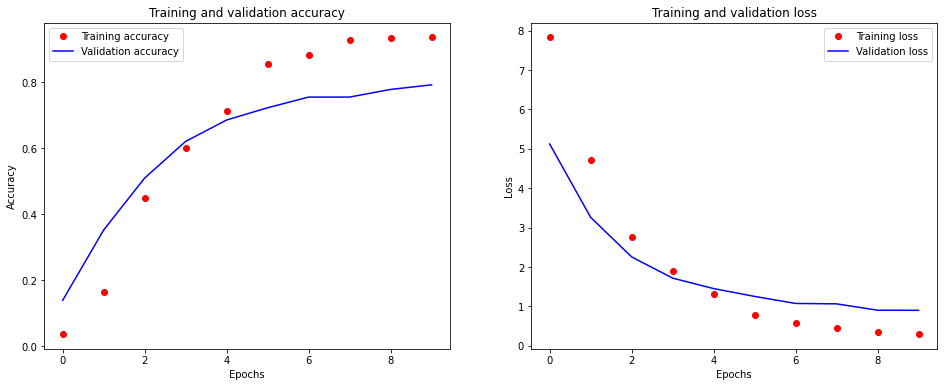

In [39]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(len(acc))


fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, figsize=(16,6))
# bo -> blue dot
# b -> solid blue line
ax0.plot(epochs, acc, 'bo', label='Training accuracy', color='r')
ax0.plot(epochs, val_acc, 'b', label='Validation accuracy')
ax0.set(
    title='Training and validation accuracy',
    xlabel='Epochs',
    ylabel='Accuracy'
)
ax0.legend()
#################################
ax1.plot(epochs, loss, 'bo', label='Training loss', color='r')
ax1.plot(epochs, val_loss, 'b', label='Validation loss')
ax1.set(
    title='Training and validation loss',
    xlabel='Epochs',
    ylabel='Loss'
)
ax1.legend()

plt.show()

Se observa que la precisión del entrenamiento incrementa casi linealmente hasta alcanzar cotas muy altas(aunque al final experimenta un pequño decremento) mientras que la precisión de validación aunque al principio parece seguir la misma pauta que la de entrenamiento, llega un momento en la que se estanca y no crece más.

Pasa lo mismo con la pérdida para el set de entrenamiento, decrece hasta alcanzar casi el 0, mientras que la de validación decrece, pero en un determinado punto(a partir del epoch 8) vuelve a subir.

Posiblemente esto se deba a que contamos con pocas muestras.
TODO: probar data augmentation

### Cargamos modelo previo

In [40]:
from keras.models import load_model

modelV1 = load_model('VGG-16_v1.h5')
modelV1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Se evalúa el modelo con el dataset de testeo que hemos dejado apartado.

In [43]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_path,
                                            target_size=IMAGE_SIZE,
                                            batch_size=32,
                                            class_mode='categorical')

test_loss, test_acc = modelV1.evaluate(test_generator, steps=len(test_generator))

Found 216 images belonging to 108 classes.
7/7 [==============================] - 31s 4s/step - loss: 1.0840 - accuracy: 0.7778


In [44]:
test_acc

0.7777777910232544

Obtenemos una precisión del 77%